In [1]:
import random
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from src.model_rt import RealtimeModel, svc, linear_svc, nu_svc, lda, qda
from src.utils_import import load_data
from src.utils_preprocess import split_data, compute_energy_matrix_and_labels
from src.utils_preprocess import *


random.seed(1337)
np.random.seed(1337)

# Asumption: all signals consist of 50k samples
n_samples = 50000
interv = 1024 # Hyperparameter 1
array_length = (n_samples // interv) - 1
n_frec_div = 32 # Hyperparameter 2

# Load data
signals_clean = load_data('dataset/Jamming/Clean', 'dataset/Jamming/metadata.csv')
signals_narrowband = load_data('dataset/Jamming/Narrowband', 'dataset/Jamming/metadata.csv')
signals_wideband = load_data('dataset/Jamming/Wideband', 'dataset/Jamming/metadata.csv')

# Partition train=0.8, test=0.2
clean_train, clean_test = split_data(signals_clean, 0.8)
narrowband_train, narrowband_test = split_data(signals_narrowband, 0.8)
wideband_train, wideband_test = split_data(signals_wideband, 0.8)

train = clean_train + narrowband_train + wideband_train
test = clean_test + narrowband_test + wideband_test

print(f"Nº señales entrenamiento: {len(train)}")
print(f"Nº señales test: {len(test)}")

random.shuffle(train)
random.shuffle(test)

class_mapping = {"Clean": 0, "Narrowband Start": 1, "Narrowband Stop": 2, "Wideband Start": 3, "Wideband Stop": 4}
class_unmapping = {v:k for k,v in class_mapping.items()}


7500it [00:06, 1237.42it/s]
7500it [00:06, 1224.22it/s]
7500it [00:06, 1229.39it/s]

Nº señales entrenamiento: 18000
Nº señales test: 4500


(48, 1024)


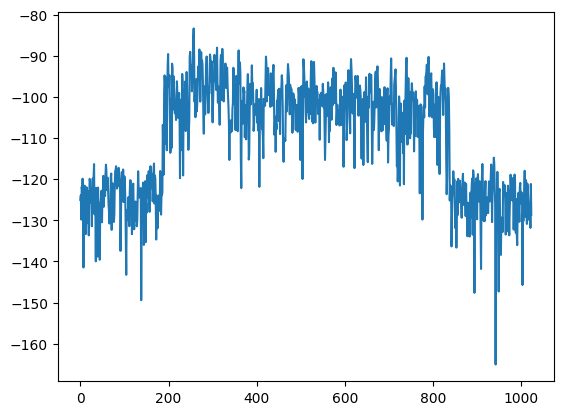

{'Data': array([-0.02951139-0.03698843j,  0.00030519-0.00030519j,
        0.00158696+0.01062044j, ..., -0.03268532+0.01327555j,
       -0.01016266+0.02133243j,  0.00833155+0.03701894j], dtype=complex64), 'Class': 'Narrowband', 'JammingStartTime': np.int64(13326), 'AveragePower_dB': np.float64(-28.87519359588623)}
(48, 1024)


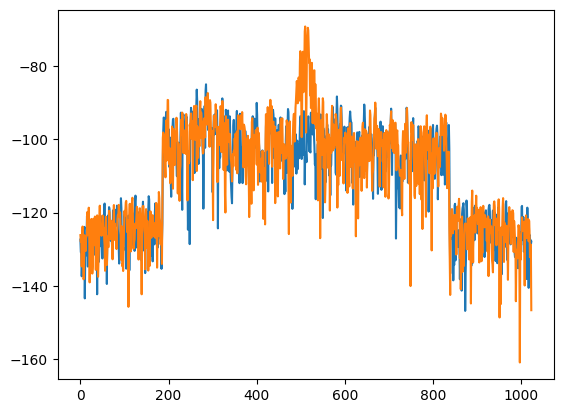

{'Data': array([ 0.06189152-0.00094607j,  0.02996917-0.01736503j,
       -0.02877895+0.00695822j, ...,  0.02069154-0.00323496j,
        0.05496382-0.00378429j,  0.00469985-0.00555437j], dtype=complex64), 'Class': 'Wideband', 'JammingStartTime': np.int64(12773), 'AveragePower_dB': np.float64(-28.82474184036255)}
(48, 1024)


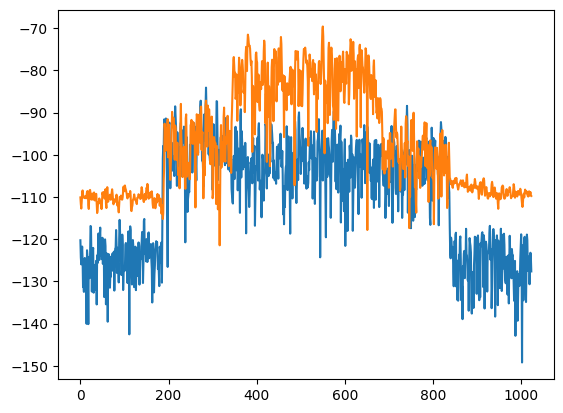

----------------------------------------------------------------------------------------------------
[[-132.83255 +0.j -126.86225 +0.j -120.010956+0.j ... -124.27451 +0.j
  -129.96368 +0.j -152.49312 +0.j]
 [-120.24972 +0.j -124.33    +0.j -125.963135+0.j ... -123.20736 +0.j
  -124.330894+0.j -127.6324  +0.j]
 [-110.09662 +0.j -111.677795+0.j -112.73477 +0.j ... -108.81985 +0.j
  -109.608376+0.j -109.74883 +0.j]]
[[-0.02093226  0.00148698 -0.03871095 -0.01464876 -0.0464496   0.01727955
   0.02048479 -0.0041203   0.00873459  0.05258286  0.00079624  0.00059813
  -0.00975289  0.00609788 -0.02499658 -0.01005171]
 [-0.26856637 -0.25184962 -0.20783862 -0.04709355  0.03837921 -0.29815152
  -0.41745988 -0.44244045 -0.43735358 -0.49089387 -0.26901338 -0.07878731
  -0.01416742 -0.30532974 -0.26865673 -0.30225652]]


In [2]:
d = train[0]["Data"] # Clean
f = signal_interval(d)
print(f.shape)
plt.plot(np.real(f[20]))
plt.show()

d = train[1]["Data"] # Narrowband
start = train[1]['JammingStartTime']//1024
print(train[1])
f = signal_interval(d)
print(f.shape)
plt.plot(np.real(f[start-1]))
plt.plot(np.real(f[start]))
plt.show()


d = train[6]["Data"] # Wideband
start = train[6]['JammingStartTime']//1024
print(train[6])
f = signal_interval(d)
print(f.shape)
plt.plot(np.real(f[start-1]))
plt.plot(np.real(f[start]))
plt.show()

t = f[start-2:start+1]
print("-"*100)
print(t)
e=energy_arrays(t, 16)
print(e)

In [3]:
# 1) -- Train --
# Building energy arrays for each train signal (x=window samples, y=frecuency divisions z=signal)
train_energy_dif_matrix, sample_labels = compute_energy_matrix_and_labels(train, n_samples, interv, n_frec_div, class_mapping, balance_data=True)

# 2) -- Test --
test_energy_dif_matrix, y_true = compute_energy_matrix_and_labels(test, n_samples, interv, n_frec_div, class_mapping)


18000it [00:57, 315.65it/s]
4500it [00:14, 314.90it/s]


In [4]:
# 1) -- Train --

svc_model = svc(train_energy_dif_matrix, sample_labels)
lin_svc = linear_svc(train_energy_dif_matrix, sample_labels)
nu_SVC = nu_svc(train_energy_dif_matrix, sample_labels)
lda_model = lda(train_energy_dif_matrix, sample_labels)
qda_model = qda(train_energy_dif_matrix, sample_labels)

# 2) -- Test -- 

y_pred = svc_model.predict(test_energy_dif_matrix)
y_pred2 = lin_svc.predict(test_energy_dif_matrix)
y_pred3 = nu_SVC.predict(test_energy_dif_matrix)
y_pred4 = lda_model.predict(test_energy_dif_matrix)
y_pred5 = qda_model.predict(test_energy_dif_matrix)

# 3) -- Metrics --

print("\n-- SVC --")

acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc}")        

cm = confusion_matrix(y_true, y_pred)
print(f"\nConfusion Matrix:\n{cm}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

#

print("\n-- Linear SVC --")

acc = accuracy_score(y_true, y_pred2)
print(f"\nAccuracy: {acc}")        

cm = confusion_matrix(y_true, y_pred2)
print(f"\nConfusion Matrix:\n{cm}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred2, digits=4))

#

print("\n-- Nu SVC --")

acc = accuracy_score(y_true, y_pred3)
print(f"\nAccuracy: {acc}")        

cm = confusion_matrix(y_true, y_pred3)
print(f"\nConfusion Matrix:\n{cm}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred3, digits=4))

#

print("\n-- LDA --")

acc = accuracy_score(y_true, y_pred4)
print(f"\nAccuracy: {acc}")        

cm = confusion_matrix(y_true, y_pred4)
print(f"\nConfusion Matrix:\n{cm}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred4, digits=4))

#

print("\n-- QDA --")

acc = accuracy_score(y_true, y_pred5)
print(f"\nAccuracy: {acc}")        

cm = confusion_matrix(y_true, y_pred5)
print(f"\nConfusion Matrix:\n{cm}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred5, digits=4))


-- SVC --

Accuracy: 0.9996

Confusion Matrix:
[[1499    0    1    0    0]
 [   1 1499    0    0    0]
 [   1    0 1499    0    0]
 [   0    0    0 1500    0]
 [   0    0    0    0 1500]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9993    0.9990      1500
           1     1.0000    0.9993    0.9997      1500
           2     0.9993    0.9993    0.9993      1500
           3     1.0000    1.0000    1.0000      1500
           4     1.0000    1.0000    1.0000      1500

    accuracy                         0.9996      7500
   macro avg     0.9996    0.9996    0.9996      7500
weighted avg     0.9996    0.9996    0.9996      7500


-- Linear SVC --

Accuracy: 0.9972

Confusion Matrix:
[[1479   10   11    0    0]
 [   0 1500    0    0    0]
 [   0    0 1500    0    0]
 [   0    0    0 1500    0]
 [   0    0    0    0 1500]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000

In [5]:
fold = StratifiedKFold(5)
model = KNeighborsClassifier()
parameters = {"n_neighbors":list(range(1,31)), "weights":("uniform","distance")}
clf = GridSearchCV(model, parameters, cv=fold, refit=True)
clf.fit(train_energy_dif_matrix, sample_labels)
best_params = clf.best_params_ 

# leaf_size only affects execution time, so it's done separately
model = KNeighborsClassifier(**best_params)
clf = GridSearchCV(model, {"leaf_size":[20,30,50,100,200,300,400]}, cv=fold, refit=True)
clf.fit(train_energy_dif_matrix, sample_labels)
best_index = np.argmin(clf.cv_results_['mean_fit_time'])
best_params['leaf_size'] = clf.cv_results_['params'][best_index]['leaf_size']

model = clf.best_estimator_
y_hat = model.predict(test_energy_dif_matrix)
acc = accuracy_score(y_true, y_hat)

print("KNN")

# Accuracy
acc = accuracy_score(y_true, y_hat)
print(f"\nAccuracy: {acc}")        

# Confusion Matrix
cm = confusion_matrix(y_true, y_hat)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_true, y_hat, digits=4))

KNN

Accuracy: 0.9994666666666666

Confusion Matrix:
[[1500    0    0    0    0]
 [   1 1499    0    0    0]
 [   3    0 1497    0    0]
 [   0    0    0 1500    0]
 [   0    0    0    0 1500]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9973    1.0000    0.9987      1500
           1     1.0000    0.9993    0.9997      1500
           2     1.0000    0.9980    0.9990      1500
           3     1.0000    1.0000    1.0000      1500
           4     1.0000    1.0000    1.0000      1500

    accuracy                         0.9995      7500
   macro avg     0.9995    0.9995    0.9995      7500
weighted avg     0.9995    0.9995    0.9995      7500



In [6]:
realtime_model = RealtimeModel(svc_model, classes = {"Clean": 0, 
                                                    "Narrowband Start": 1, 
                                                    "Narrowband Stop": 2, 
                                                    "Wideband Start": 3, 
                                                    "Wideband Stop": 4}, 
                                        class_map = {0: "Clean", 
                                                    1: "Narrowband", 
                                                    2: "Clean", 
                                                    3: "Wideband", 
                                                    4: "Clean"}, 
                                        class_type = {0: "Clean", 
                                                    1: "Narrowband", 
                                                    2: "Narrowband", 
                                                    3: "Wideband", 
                                                    4: "Wideband"},
                                        offset=4,
                                        nfft=interv, n_partitions=n_frec_div, verbose=True)
#print(test[0]["Data"])
pred = realtime_model.classificate_recordings(test)

y_signal_true = [s["Class"] for s in test]
y_hat = [s["Class"] for s in pred]

# Accuracy
acc = accuracy_score(y_signal_true, y_hat)
print(f"\nAccuracy: {acc}")        

# Confusion Matrix
cm = confusion_matrix(y_signal_true, y_hat)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_signal_true, y_hat, digits=4))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FDR = FP/(TP+FP)

print("False discovery rate:", FDR)
print("Average false discovery rate:", round(np.mean(FDR), 4))

1604it [00:07, 211.12it/s]

[2] [0] 2 2 8192 21504


4500it [00:21, 211.62it/s]



Accuracy: 0.9997777777777778

Confusion Matrix:
[[1500    0    0]
 [   1 1499    0]
 [   0    0 1500]]

Classification Report:
              precision    recall  f1-score   support

       Clean     0.9993    1.0000    0.9997      1500
  Narrowband     1.0000    0.9993    0.9997      1500
    Wideband     1.0000    1.0000    1.0000      1500

    accuracy                         0.9998      4500
   macro avg     0.9998    0.9998    0.9998      4500
weighted avg     0.9998    0.9998    0.9998      4500

False discovery rate: [0.00066622 0.         0.        ]
Average false discovery rate: 0.0002


In [7]:
display(pred[:10])

[{'Class': 'Wideband', 'Start': np.int64(18432), 'Stop': np.int64(30720)},
 {'Class': 'Narrowband', 'Start': np.int64(15360), 'Stop': np.int64(30720)},
 {'Class': 'Wideband', 'Start': np.int64(16384), 'Stop': np.int64(28672)},
 {'Class': 'Clean', 'Start': None, 'Stop': None},
 {'Class': 'Wideband', 'Start': np.int64(11264), 'Stop': np.int64(23552)},
 {'Class': 'Narrowband', 'Start': np.int64(13312), 'Stop': np.int64(25600)},
 {'Class': 'Wideband', 'Start': np.int64(19456), 'Stop': np.int64(31744)},
 {'Class': 'Wideband', 'Start': np.int64(14336), 'Stop': np.int64(26624)},
 {'Class': 'Clean', 'Start': None, 'Stop': None},
 {'Class': 'Wideband', 'Start': np.int64(18432), 'Stop': np.int64(31744)}]

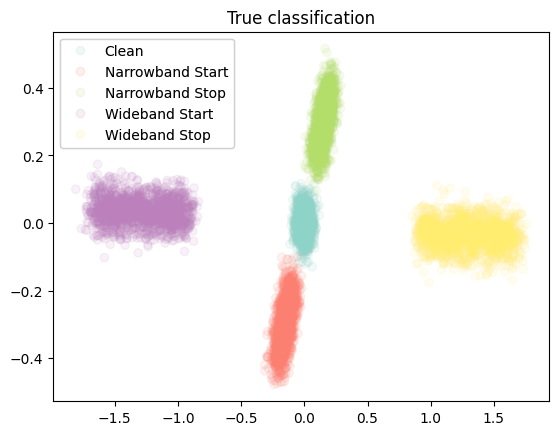

In [8]:
pca = PCA(2) 
X = test_energy_dif_matrix
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
pca_data['cluster'] = pd.Categorical(y_true)

fig,ax = plt.subplots()
scatter = ax.scatter(pca_data['PC1'], pca_data['PC2'],c=pca_data['cluster'],cmap='Set3',alpha=0.1)
legend1 = ax.legend(scatter.legend_elements()[0], class_mapping.keys(), # WARNING: labels could be wrong
                    loc="upper left", title="")
ax.add_artist(legend1)
plt.title("True classification")
plt.show()

In [9]:
display(np.bincount(sample_labels))

array([6000, 6000, 6000, 6000, 6000])